# CNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%pylab inline

import torch

from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid

import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Populating the interactive namespace from numpy and matplotlib


In [2]:
trainset = datasets.CIFAR100(root='./data', train=True, download=True)
testset = datasets.CIFAR100(root='./data', train=False, download=True)
num_classes = 100

#trainset = datasets.CIFAR10(root='./data', train=True, download=True)
#testset = datasets.CIFAR10(root='./data', train=False, download=True)
#num_classes = 10

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

class MyOwnCifar(Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

In [4]:
def imshow(ax, img, title):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(title)

In [5]:
def show_image_example(transforms):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,10))

    image, label = train_dataset[0]
    imshow(ax1, transforms(image), label)

    image, label = valid_dataset[0]
    imshow(ax2, transforms(image), label)

    image, label = testset[0]
    imshow(ax3, transforms(image), label)

In [6]:
class Net(nn.Module):

    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.bn_one = nn.BatchNorm2d(3) 
        self.conv_one = nn.Conv2d(3, 30, 3)
        self.bn_two = nn.BatchNorm2d(30) 
        self.conv_two = nn.Conv2d(30, 60, 3)
        self.bn_three = nn.BatchNorm2d(60)
        self.conv_three = nn.Conv2d(60, 120, 3)
        self.bn_four = nn.BatchNorm2d(120)
        self.dp_three = nn.Dropout(0.2)
        self.fc1 = nn.Linear(480, 200)
        self.dp_four = nn.Dropout(0.2)
        self.fc2 = nn.Linear(200, 60)
        self.out = nn.Linear(60, num_classes)
        
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net(num_classes)
print(net)

Net(
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp_three): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=480, out_features=200, bias=True)
  (dp_four): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=200, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=100, bias=True)
)


In [7]:
class Trainer():
    """
    Parameters:
        dataset: пользовательский класс, предобрабатывающий данные
        trans_actions: преобразования тренировочных данных
        valid_transforms: преобразования валидационных данных
        loss_f: функция потерь
        learning_rate: величина градиентного шага
        epoch_amount: общее количество эпох
        batch_size: размер одного бача
        max_batches_per_epoch: максимальное количество батчей, 
                               подаваемых в модель в одну эпоху
        device: устройство для вычислений
        early_stopping: количество эпох без улучшений до остановки обучения
        
        optim: оптимизатор
        params_to_update: список обучаемых параметров
        
        scheduler: регулятор градиентного шага
        permutate: перемешивание тренировочной выборки перед обучением

    Attributes:
        start_model: необученная модель
        best_model: модель, после обучения
        train_loss: средние значения функции потерь на тренировочных 
                    данных в каждой эпохе
        val_loss: средние значения функции потерь на валидационных 
                  данных в каждой эпохе

    Methods:
        fit: обучение модели
        predict: возвращает предсказание обученной моделью

    """
    def __init__(self,  dataset, net, loss_f,
                 trans_actions=transforms.ToTensor(),
                 valid_transforms=transforms.ToTensor(),
                 transform=None,
                 learning_rate=1e-3, 
                 epoch_amount=10, batch_size=12,
                 max_batches_per_epoch=None,
                 device='cpu', early_stopping=10,
                 optim=torch.optim.Adam,
                 params_to_update=None,
                 scheduler=None, permutate=True):
        
        self.loss_f = loss_f
        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.device = device
        self.early_stopping = early_stopping
        
        self.optim = optim
        self.params_to_update = params_to_update
        
        self.scheduler = scheduler
        self.permutate = permutate
        self.dataset = dataset
        self.trans_actions = trans_actions
        self.valid_transforms = valid_transforms
        
        self.start_model = net
        self.best_model = net

        self.train_loss = []
        self.val_loss = []
    
    def predict(self, X):
        return self.best_model(X)

    def fit(self, train_dataset, valid_dataset):

        Net = self.start_model
            
        device = torch.device(self.device)

        Net.to(self.device)

        if self.params_to_update is not None:
            optimizer = self.optim(self.params_to_update, lr=self.learning_rate)
        else:
            optimizer = self.optim(Net.parameters(), lr=self.learning_rate)

        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer)

        train = self.dataset(train_dataset, self.trans_actions)
        val = self.dataset(valid_dataset, self.valid_transforms)  

        train = DataLoader(train, batch_size=self.batch_size, shuffle=self.permutate) 
        val = DataLoader(val, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf') # Лучшее значение функции потерь на валидационной выборке
        best_ep = 0                  # Эпоха, на которой достигалось лучшее 
                                     # значение функции потерь на валидационной выборке

        for epoch in range(self.epoch_amount): 
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            Net.train()
            mean_loss = 0
            batch_n = 0

            for batch_X, target in train:
                if self.max_batches_per_epoch is not None:
                    if batch_n >= self.max_batches_per_epoch:
                        break
                optimizer.zero_grad()

                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)
                loss.backward()
                optimizer.step()

                mean_loss += float(loss)
                batch_n += 1
        
            mean_loss /= batch_n
            self.train_loss.append(mean_loss)
            print(f'Loss_train: {mean_loss}, {dt.datetime.now() - start} сек')

            Net.eval()
            mean_loss = 0
            batch_n = 0

            with torch.no_grad():
                for batch_X, target in val:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)

                mean_loss += float(loss)
                batch_n += 1
        
            mean_loss /= batch_n
            self.val_loss.append(mean_loss)
            print(f'Loss_val: {mean_loss}')

            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()

    def save_model(self, PATH):
        torch.save(self.best_model.state_dict(), PATH)

    def load_model(self, PATH):
         self.best_model.load_state_dict(torch.load(PATH))       
        
    def get_clf_results(self, test_dataset):
        test = self.dataset(test_dataset, self.valid_transforms)
        test = DataLoader(test, batch_size=self.batch_size, shuffle=False)
        
        true_labels = []
        pred_labels = []
        with torch.no_grad():
            for batch_X, labels in test:
                true_labels += list(labels.numpy())
                batch_X = batch_X.to(self.device)
                labels = labels.to(self.device)

                outputs = self.predict(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                
                pred_labels += list(predicted.numpy())
        return true_labels, pred_labels 

## 1. Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) сверточной сетью (самописной)

In [8]:
trans_actions = transforms.ToTensor()

In [9]:
train_dataset, valid_dataset = train_valid_split(trainset)

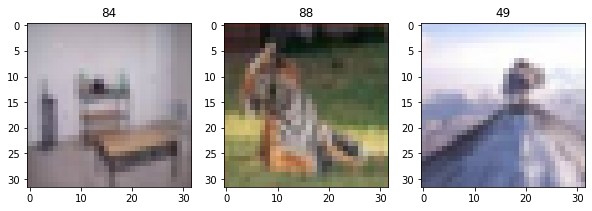

In [10]:
show_image_example(trans_actions)

In [11]:
params = {
    'dataset': MyOwnCifar,
    'net': net,
    'batch_size': 128,
    'epoch_amount': 10, 
    'learning_rate': 1e-2,
    'early_stopping': 3,
    'loss_f': nn.CrossEntropyLoss(),
    'optim': torch.optim.Adam,
}

clf1 = Trainer(**params)

In [12]:
clf1.fit(train_dataset, valid_dataset)

Эпоха: 0 Loss_train: 3.966303785001078, 0:00:39.603533 сек
Loss_val: 3.794835329055786

Эпоха: 1 Loss_train: 3.518687311039176, 0:00:39.450321 сек
Loss_val: 3.5334506034851074

Эпоха: 2 Loss_train: 3.2690406839052835, 0:00:42.134204 сек
Loss_val: 3.2560689449310303

Эпоха: 3 Loss_train: 3.0902026731480836, 0:00:42.055324 сек
Loss_val: 3.2545158863067627

Эпоха: 4 Loss_train: 2.9651818204951543, 0:00:43.181854 сек
Loss_val: 2.9659011363983154

Эпоха: 5 Loss_train: 2.861041928491285, 0:00:39.216433 сек
Loss_val: 3.1275124549865723

Эпоха: 6 Loss_train: 2.78701957579582, 0:00:42.072391 сек
Loss_val: 2.7972965240478516

Эпоха: 7 Loss_train: 2.7084093850146056, 0:00:39.897849 сек
Loss_val: 3.0775246620178223

Эпоха: 8 Loss_train: 2.643089211115273, 0:00:40.424223 сек
Loss_val: 2.7454545497894287

Эпоха: 9 Loss_train: 2.5929511984189353, 0:00:40.793906 сек
Loss_val: 2.520540952682495



In [13]:
PATH = './models/cifar' + str(num_classes) + '_CNN.pth'
clf1.save_model(PATH)

In [14]:
#clf1.load_model(PATH)

In [15]:
true_labels, pred_labels = clf1.get_clf_results(testset)

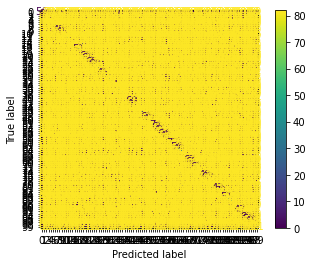

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_labels, pred_labels))
disp.plot()

In [17]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.81      0.56      0.66       100
           1       0.31      0.60      0.41       100
           2       0.33      0.01      0.02       100
           3       0.18      0.22      0.20       100
           4       0.17      0.03      0.05       100
           5       0.17      0.30      0.22       100
           6       0.48      0.29      0.36       100
           7       0.44      0.23      0.30       100
           8       0.48      0.42      0.45       100
           9       0.47      0.45      0.46       100
          10       0.39      0.14      0.21       100
          11       0.22      0.17      0.19       100
          12       0.50      0.35      0.41       100
          13       0.27      0.03      0.05       100
          14       0.37      0.19      0.25       100
          15       0.19      0.30      0.24       100
          16       0.42      0.28      0.34       100
          17       0.52    

## 2. Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50

In [18]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)

In [19]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [21]:
set_parameter_requires_grad(resnet50, True)

In [22]:
fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(2048, 200),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(200, 60),
        nn.ReLU(),
        nn.Linear(60, num_classes))

resnet50.fc = fc
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
params_to_update = []
for name,param in resnet50.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

params_to_update

[Parameter containing:
 tensor([[-0.0157, -0.0217,  0.0063,  ...,  0.0128, -0.0018, -0.0115],
         [ 0.0151,  0.0178,  0.0130,  ..., -0.0066, -0.0022,  0.0048],
         [-0.0178,  0.0162,  0.0089,  ...,  0.0074, -0.0220, -0.0171],
         ...,
         [ 0.0064, -0.0088, -0.0040,  ...,  0.0060,  0.0163,  0.0166],
         [-0.0218, -0.0092, -0.0203,  ..., -0.0198,  0.0039,  0.0137],
         [ 0.0104,  0.0162,  0.0128,  ...,  0.0040, -0.0042,  0.0053]],
        requires_grad=True),
 Parameter containing:
 tensor([-2.1270e-02,  7.0395e-03,  1.1480e-02,  1.4511e-02,  1.9297e-02,
          1.6287e-02, -1.0946e-02, -5.5087e-03, -1.8643e-02,  1.5353e-02,
          1.2556e-02, -1.7687e-02, -9.8118e-03,  5.6500e-03, -8.2060e-03,
          5.2571e-03,  2.2666e-03, -2.1980e-03, -6.1183e-04, -1.5583e-02,
         -7.4468e-03,  4.8081e-03, -1.8773e-03, -1.8700e-02,  2.0589e-02,
          1.7626e-02, -1.9744e-02, -7.5094e-03, -1.7996e-02,  7.8895e-03,
         -8.0605e-03, -8.5535e-03,  9.96

In [24]:
trans_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

params = {
    'dataset': MyOwnCifar,
    'trans_actions': trans_actions,
    'valid_transforms': valid_transforms,
    'net': resnet50,
    'batch_size': 128,
    'max_batches_per_epoch': 10, #ограничим количество батчей на эпохе, чтобы сократить время обучения 
    'epoch_amount': 10, 
    'learning_rate': 1e-2,
    'early_stopping': 3,
    'loss_f': nn.CrossEntropyLoss(),
    'optim': torch.optim.Adam,
    'params_to_update': params_to_update
}

clf2 = Trainer(**params)

In [25]:
clf2.fit(train_dataset, valid_dataset)

Эпоха: 0 Loss_train: 4.937615633010864, 0:02:06.523786 сек
Loss_val: 4.601932048797607

Эпоха: 1 Loss_train: 4.610767221450805, 0:02:09.924364 сек
Loss_val: 4.600284576416016

Эпоха: 2 Loss_train: 4.603227233886718, 0:02:03.847786 сек
Loss_val: 4.600622653961182

Эпоха: 3 Loss_train: 4.609421491622925, 0:02:05.841918 сек
Loss_val: 4.599883079528809

Эпоха: 4 Loss_train: 4.609887647628784, 0:02:09.428580 сек
Loss_val: 4.601587295532227

Эпоха: 5 Loss_train: 4.6057483673095705, 0:02:10.049149 сек
Loss_val: 4.602947235107422

Эпоха: 6 Loss_train: 4.609599781036377, 0:02:08.679627 сек
Loss_val: 4.602898597717285

Эпоха: 7 Loss_train: 4.604419851303101, 0:02:08.661451 сек
Loss_val: 4.605533123016357
3 без улучшений. Прекращаем обучение...


In [26]:
PATH = './models/cifar' + str(num_classes) + '_RN50.pth'
clf2.save_model(PATH)

In [27]:
#clf2.load_model(PATH)

In [28]:
true_labels, pred_labels = clf2.get_clf_results(testset)

In [29]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.00      0.00      0.00       100
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00       100
           8       0.00      0.00      0.00       100
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00       100
          11       0.00      0.00      0.00       100
          12       0.00      0.00      0.00       100
          13       0.00      0.00      0.00       100
          14       0.00      0.00      0.00       100
          15       0.00      0.00      0.00       100
          16       0.00      0.00      0.00       100
          17       0.00    

C:\Users\Kartsev.ES\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kartsev.ES\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kartsev.ES\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
print(net)

Net(
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp_three): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=480, out_features=200, bias=True)
  (dp_four): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=200, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=100, bias=True)
)


## 3. Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50 с аугментацией (самописной, с использованием Pytorch встроенных методов)

In [31]:
trans_aug = transforms.Compose([transforms.Resize(256),
                                    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                                    transforms.RandomRotation(degrees=(-45, 45)),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor()])

trans_actions = transforms.Compose([trans_aug,
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

params = {
    'dataset': MyOwnCifar,
    'trans_actions': trans_actions,
    'valid_transforms': valid_transforms,
    'net': resnet50,
    'batch_size': 128,
    'max_batches_per_epoch': 10, #ограничим количество батчей на эпохе, чтобы сократить время обучения 
    'epoch_amount': 10, 
    'learning_rate': 1e-2,
    'early_stopping': 3,
    'loss_f': nn.CrossEntropyLoss(),
    'optim': torch.optim.Adam,
    'params_to_update': params_to_update
}

clf3 = Trainer(**params)

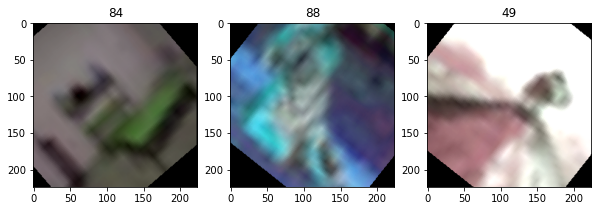

In [32]:
show_image_example(trans_aug)

In [33]:
clf3.fit(train_dataset, valid_dataset)

Эпоха: 0 Loss_train: 4.607905530929566, 0:02:12.926353 сек
Loss_val: 4.605420112609863

Эпоха: 1 Loss_train: 4.60781946182251, 0:02:11.667617 сек
Loss_val: 4.607518196105957

Эпоха: 2 Loss_train: 4.609580087661743, 0:02:13.563281 сек
Loss_val: 4.607600688934326

Эпоха: 3 Loss_train: 4.609630155563354, 0:02:12.449259 сек
Loss_val: 4.609689235687256

Эпоха: 4 Loss_train: 4.612489318847656, 0:02:13.195748 сек
Loss_val: 4.608613014221191
3 без улучшений. Прекращаем обучение...


In [34]:
PATH = './models/cifar' + str(num_classes) + 'augm_RN50.pth'
clf3.save_model(PATH)

In [35]:
true_labels, pred_labels = clf3.get_clf_results(testset)

In [36]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.00      0.00      0.00       100
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00       100
           8       0.00      0.00      0.00       100
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00       100
          11       0.00      0.00      0.00       100
          12       0.00      0.00      0.00       100
          13       0.00      0.00      0.00       100
          14       0.00      0.00      0.00       100
          15       0.00      0.00      0.00       100
          16       0.00      0.00      0.00       100
          17       0.00    

C:\Users\Kartsev.ES\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kartsev.ES\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kartsev.ES\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
